## boundary pass stats

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import seaborn as sns
import matplotlib.colors as mcolors
import glob
import os
import xarray as xr
import datetime
from salishsea_tools import viz_tools, tidetools, geo_tools, gsw_calls, wind_tools
import pickle
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [46]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

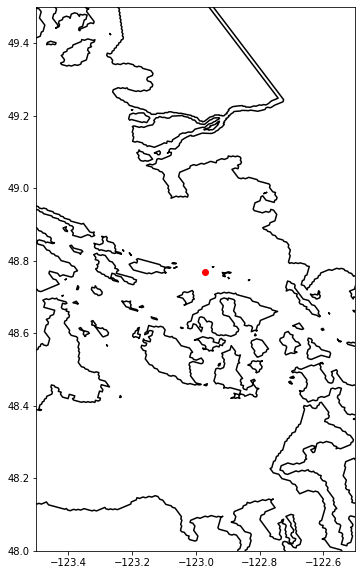

In [50]:
fig, ax = plt.subplots(figsize = (10,10))

ax.plot(-122.97, 48.77, 'ro')
ax.set_ylim(48, 49.5)
ax.set_xlim(-123.5, -122.5)
viz_tools.plot_coastline(ax, grid, coords = 'map')
viz_tools.set_aspect(ax, coords = 'map');

In [4]:
wind_grid = nc.Dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')

In [5]:
geo_tools.find_closest_model_point(-122.97, 48.77, wind_grid['longitude'][:]-360, wind_grid['latitude'][:],
                                   grid = 'GEM2.5')

(118, 158)

In [6]:
wind_data = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

In [7]:
time_slice = slice('2015-01-01 00:00:00', '2019-01-01 00:00:00')

In [8]:
u_winds = wind_data.u_wind.isel(gridY=118, gridX=158).sel(time=time_slice).data
v_winds = wind_data.v_wind.isel(gridY=118, gridX=158).sel(time=time_slice).data

In [9]:
times = wind_data.time.sel(time=time_slice).data

In [10]:
times.shape

(35065,)

In [11]:
u_winds.shape

(35065,)

In [12]:
wind_speed, wind_dir = wind_tools.wind_speed_dir(u_winds, v_winds)

In [13]:
times[:3]

array(['2015-01-01T00:00:00.000000000', '2015-01-01T01:00:00.000000000',
       '2015-01-01T02:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
wnd_dir_avg = np.array([])
wnd_dir_min = np.array([])
wnd_dir_max = np.array([])
wnd_dir_std = np.array([])

for i in range(1450):
    start = 24*i
    end = start + 168
    wnd_dir_avg = np.append(wnd_dir_avg, wind_dir[start:end].mean())
    wnd_dir_min = np.append(wnd_dir_min, wind_dir[start:end].min())
    wnd_dir_max = np.append(wnd_dir_max, wind_dir[start:end].max())
    wnd_dir_std = np.append(wnd_dir_std, wind_dir[start:end].std())

In [15]:
wnd_spd_avg = np.array([])
wnd_spd_min = np.array([])
wnd_spd_max = np.array([])
wnd_spd_std = np.array([])

for i in range(1450):
    start = 24*i
    end = start + 168
    wnd_spd_avg = np.append(wnd_spd_avg, wind_speed[start:end].mean())
    wnd_spd_min = np.append(wnd_spd_min, wind_speed[start:end].min())
    wnd_spd_max = np.append(wnd_spd_max, wind_speed[start:end].max())
    wnd_spd_std = np.append(wnd_spd_std, wind_speed[start:end].std())

In [16]:
dates2 = np.array([datetime.datetime(2015,1,1,0,30) + datetime.timedelta(hours = i) for i in range(35064)])

In [17]:
month_of_data = np.array([dates2[a].month for a in range(35064)])

In [18]:
wind_dir.shape

(35065,)

In [19]:
wind_dir2 = wind_dir[:-1]
wind_speed2 = wind_speed[:-1]

In [20]:
monthly_sal_avg = np.array([])
monthly_cur_avg = np.array([])
monthly_wnd_dir_avg = np.array([])
monthly_wnd_spd_avg = np.array([])
for a in range(1,13):
    monthly_wnd_dir_avg = np.append(monthly_wnd_dir_avg, wind_dir2[month_of_data==a].mean())
    monthly_wnd_spd_avg = np.append(monthly_wnd_spd_avg, wind_speed2[month_of_data==a].mean())

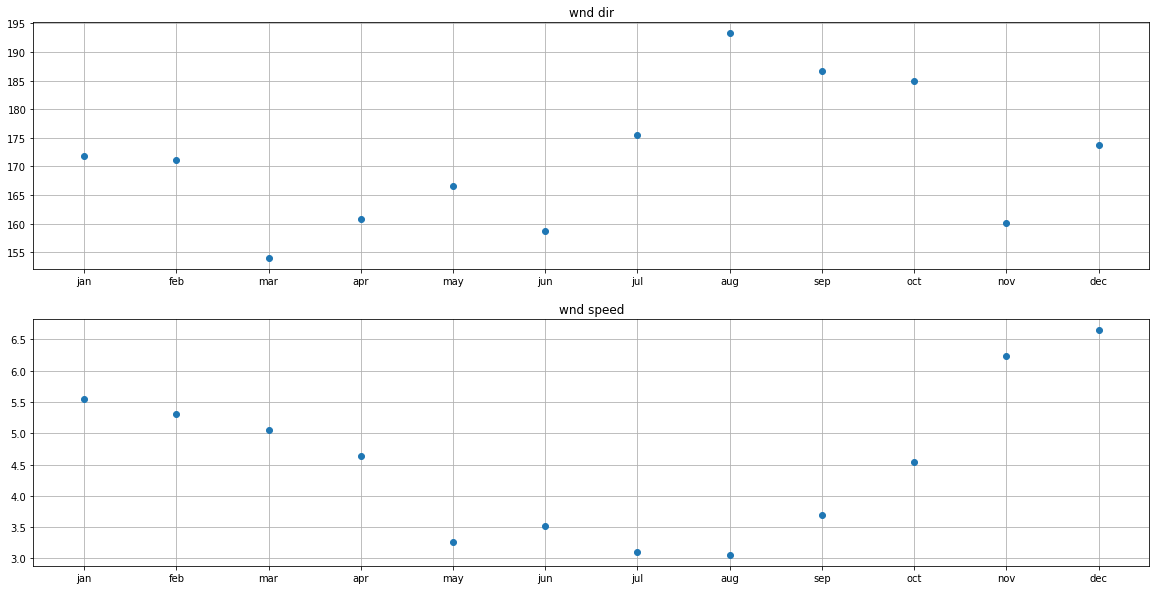

In [21]:
months = np.array(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
fig, ax = plt.subplots(2,1, figsize = (20,10))

ax[0].plot(months, monthly_wnd_dir_avg, 'o')
ax[0].set_title('wnd dir');

ax[1].plot(months, monthly_wnd_spd_avg, 'o')
ax[1].set_title('wnd speed');

for ax in ax:
    ax.grid(True);

In [22]:
dates = np.array([datetime.date(2015,1,1) + datetime.timedelta(i) for i in range(1450)])
dates.shape

(1450,)

In [23]:
print("overall mean for wind dir = " + str(wind_dir2.mean()))
print("overall mean for wind speed = " + str(wind_speed2.mean()))

overall mean for wind dir = 171.4603469344486
overall mean for wind speed = 4.545785


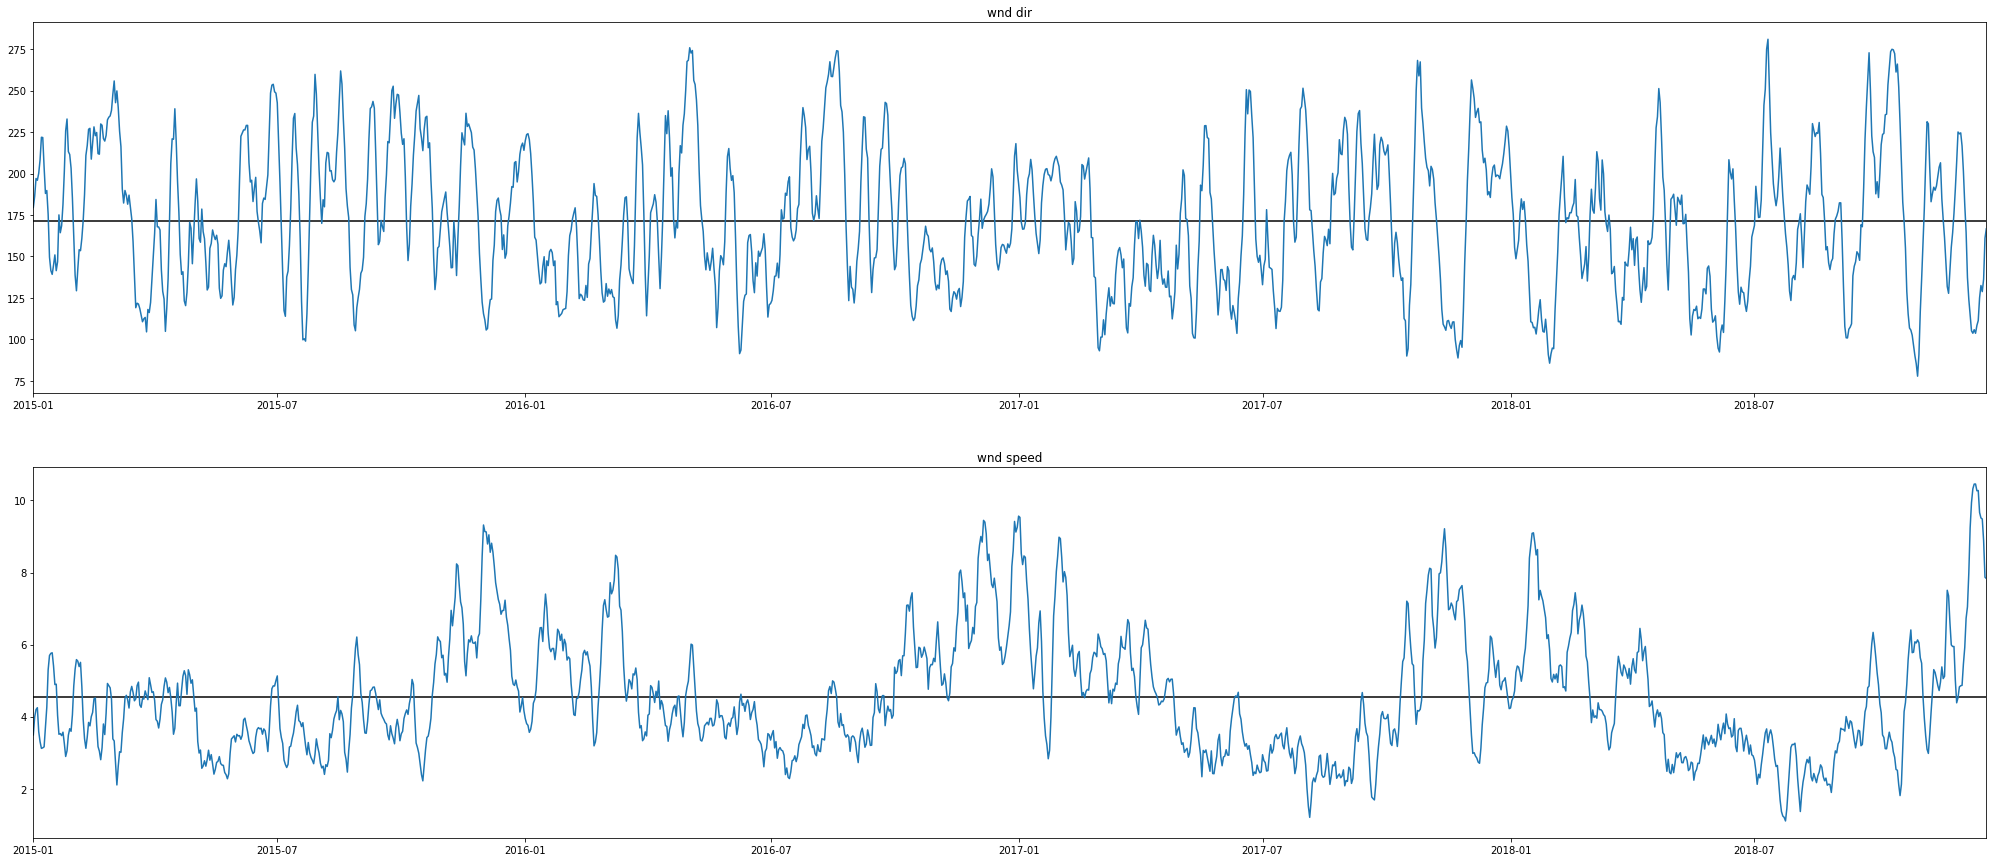

In [25]:
fig, ax = plt.subplots(2,1, figsize = (35,15))

ax[0].plot(dates,wnd_dir_avg)
ax[0].set_title('wnd dir')
ax[0].hlines(wind_dir2.mean(), dates[0], dates[-1])

ax[1].plot(dates,wnd_spd_avg)
ax[1].set_title('wnd speed')
ax[1].hlines(wind_speed2.mean(), dates[0], dates[-1])
for ax in ax:
    ax.set_xlim(dates[0], dates[-1]);
    #ax.axvline(datetime.date(2015,11,20), color='r', ls='--')
    #ax.axvline(datetime.date(2018,12,12), color='r', ls='--');
#fig.savefig('/home/vdo/Pictures/turn-choices.png', bbox_inches='tight');

In [26]:
oct2515 = pickle.load(open('/ocean/vdo/MIDOSS/25oct15.pkl', 'rb'))
jan0716 = pickle.load(open('/ocean/vdo/MIDOSS/07jan16.pkl', 'rb'))
sep3016 = pickle.load(open('/ocean/vdo/MIDOSS/30sep16.pkl', 'rb'))
oct1017 = pickle.load(open('/ocean/vdo/MIDOSS/10oct17.pkl', 'rb'))
jan1018 = pickle.load(open('/ocean/vdo/MIDOSS/10jan18.pkl', 'rb'))
nov1518 = pickle.load(open('/ocean/vdo/MIDOSS/15nov18.pkl', 'rb'))

In [27]:
oct2515['bp_wcc'].shape

(3456,)

In [28]:
wcc_avg = np.array([])
swh_avg = np.array([])
mwp_avg = np.array([])
for i in range(int(oct2515['bp_wcc'].shape[0]/48 - 7)):
    start = 48*i
    end = start + 168
    wcc_avg = np.append(wcc_avg, oct2515['bp_wcc'][start:end].mean())
    swh_avg = np.append(swh_avg, oct2515['bp_swh'][start:end].mean())
    mwp_avg = np.append(mwp_avg, oct2515['bp_mwp'][start:end].mean())

In [29]:
wcc_avg.shape

(65,)

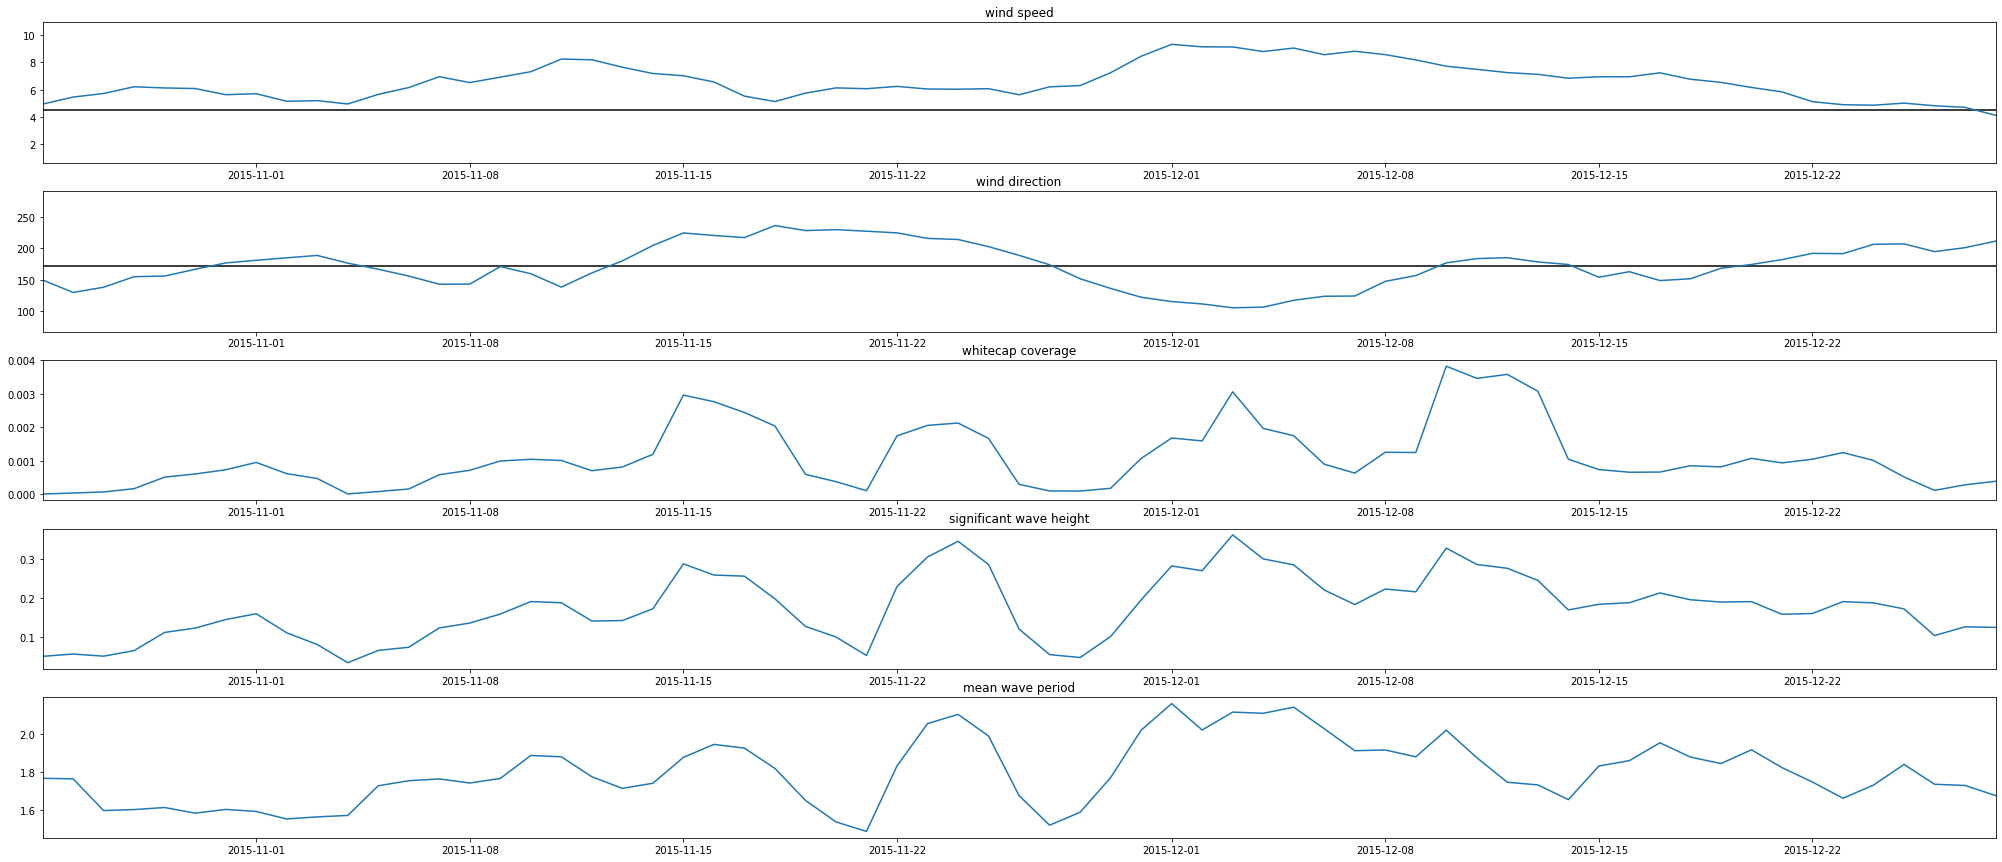

In [31]:
fig, ax = plt.subplots(5,1, figsize = (35,15))

dates2 = [datetime.date(2015,10,25) + datetime.timedelta(days = i) for i in range(65)]

ax[0].plot(dates,wnd_spd_avg)
ax[0].hlines(wind_speed2.mean(), dates2[0], dates2[-1])
ax[0].set_title('wind speed')

ax[1].plot(dates,wnd_dir_avg)
ax[1].hlines(wind_dir2.mean(), dates2[0], dates2[-1])
ax[1].set_title('wind direction')

ax[2].plot(dates2, wcc_avg)
ax[2].set_title('whitecap coverage')

ax[3].plot(dates2, swh_avg)
ax[3].set_title('significant wave height')

ax[4].plot(dates2, mwp_avg)
ax[4].set_title('mean wave period')

for a in ax:
    a.set_xlim(dates2[0], dates2[-1]);

In [35]:
wcc_avg = np.array([])
swh_avg = np.array([])
mwp_avg = np.array([])
for i in range(int(jan0716['bp_wcc'].shape[0]/48 - 7)):
    start = 48*i
    end = start + 336
    wcc_avg = np.append(wcc_avg, jan0716['bp_wcc'][start:end].mean())
    swh_avg = np.append(swh_avg, jan0716['bp_swh'][start:end].mean())
    mwp_avg = np.append(mwp_avg, jan0716['bp_mwp'][start:end].mean())
wcc_avg.shape

(74,)

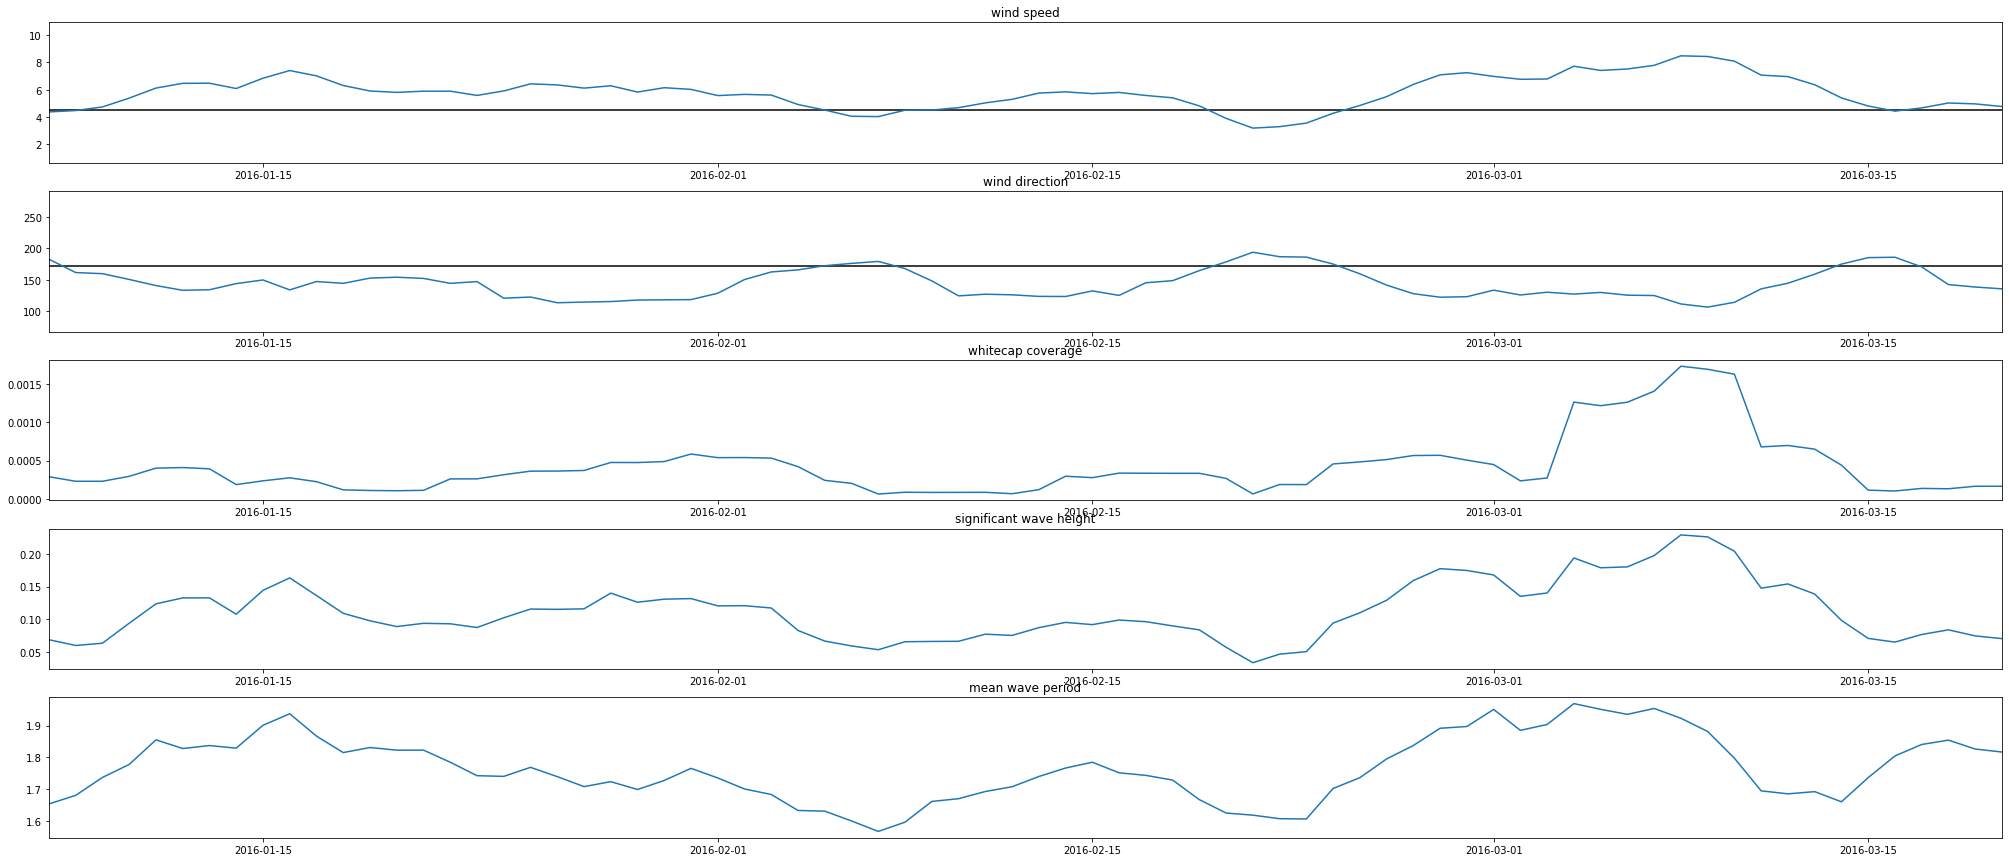

In [36]:
fig, ax = plt.subplots(5,1, figsize = (35,15))

dates2 = [datetime.date(2016,1,7) + datetime.timedelta(days = i) for i in range(74)]

ax[0].plot(dates,wnd_spd_avg)
ax[0].hlines(wind_speed2.mean(), dates2[0], dates2[-1])
ax[0].set_title('wind speed')

ax[1].plot(dates,wnd_dir_avg)
ax[1].hlines(wind_dir2.mean(), dates2[0], dates2[-1])
ax[1].set_title('wind direction')

ax[2].plot(dates2, wcc_avg)
ax[2].set_title('whitecap coverage')

ax[3].plot(dates2, swh_avg)
ax[3].set_title('significant wave height')

ax[4].plot(dates2, mwp_avg)
ax[4].set_title('mean wave period')

for a in ax:
    a.set_xlim(dates2[0], dates2[-1]);

In [38]:
wcc_avg = np.array([])
swh_avg = np.array([])
mwp_avg = np.array([])
for i in range(int(sep3016['bp_wcc'].shape[0]/48 - 7)):
    start = 48*i
    end = start + 336
    wcc_avg = np.append(wcc_avg, sep3016['bp_wcc'][start:end].mean())
    swh_avg = np.append(swh_avg, sep3016['bp_swh'][start:end].mean())
    mwp_avg = np.append(mwp_avg, sep3016['bp_mwp'][start:end].mean())
    
wcc_avg.shape

(144,)

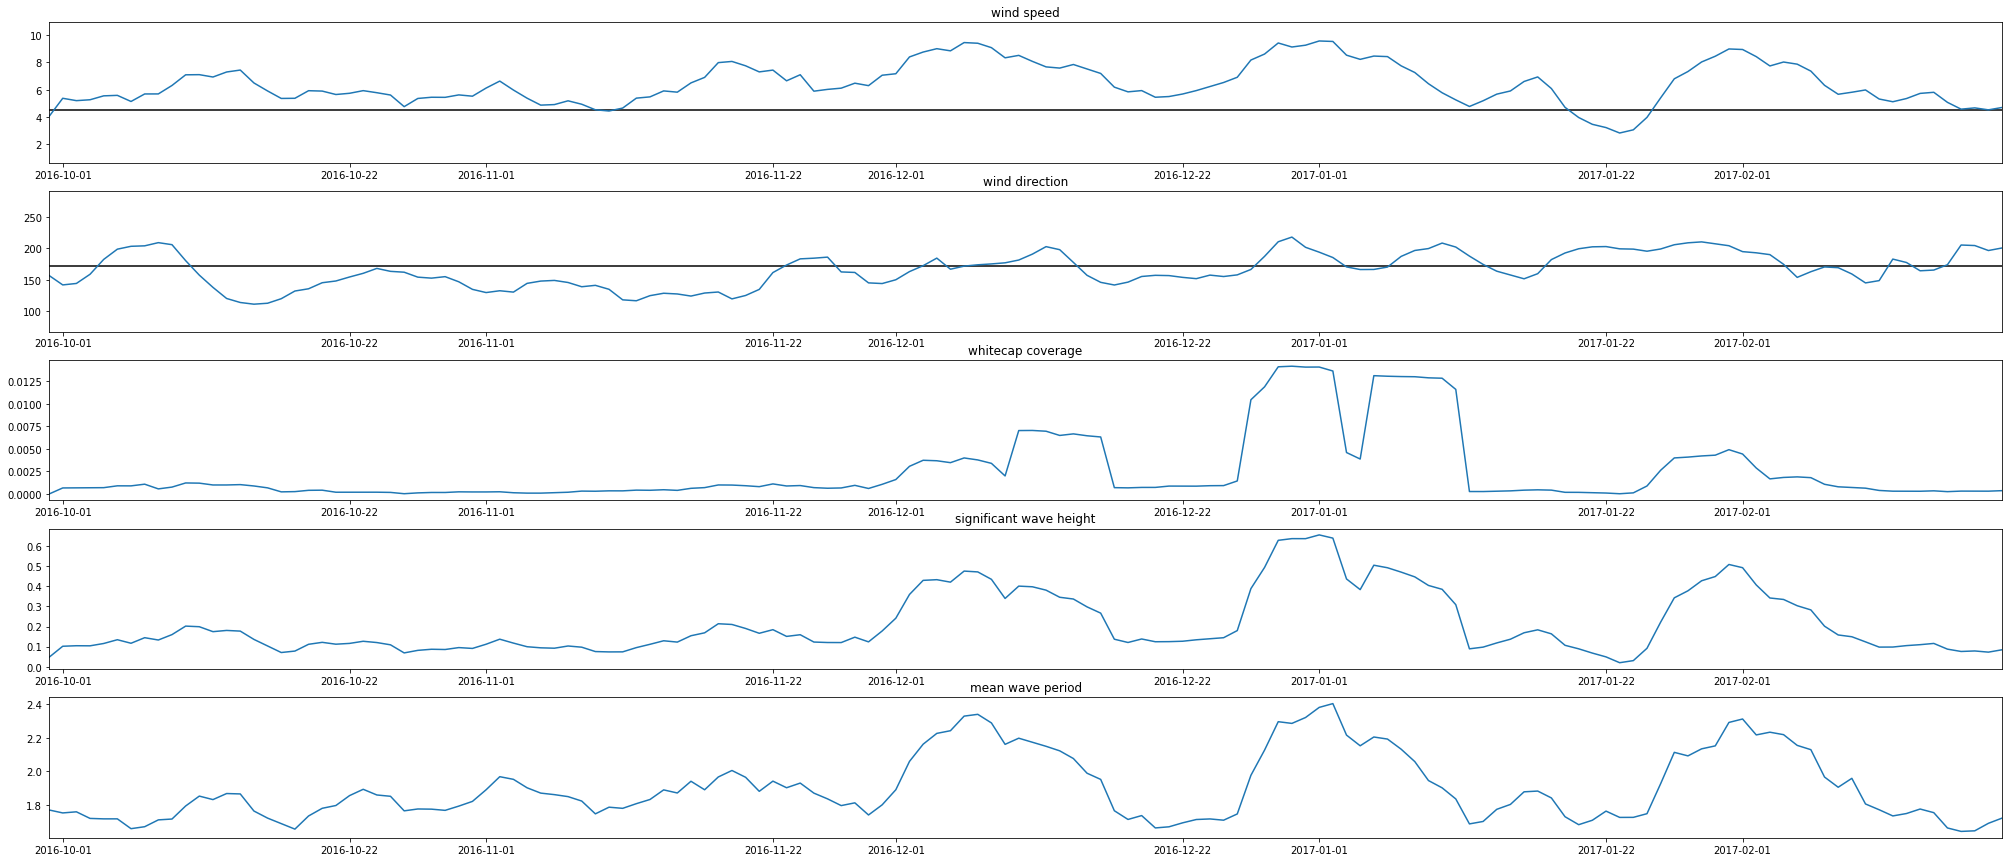

In [39]:
fig, ax = plt.subplots(5,1, figsize = (35,15))

dates2 = [datetime.date(2016,9,30) + datetime.timedelta(days = i) for i in range(144)]

ax[0].plot(dates,wnd_spd_avg)
ax[0].hlines(wind_speed2.mean(), dates2[0], dates2[-1])
ax[0].set_title('wind speed')

ax[1].plot(dates,wnd_dir_avg)
ax[1].hlines(wind_dir2.mean(), dates2[0], dates2[-1])
ax[1].set_title('wind direction')

ax[2].plot(dates2, wcc_avg)
ax[2].set_title('whitecap coverage')

ax[3].plot(dates2, swh_avg)
ax[3].set_title('significant wave height')

ax[4].plot(dates2, mwp_avg)
ax[4].set_title('mean wave period')

for a in ax:
    a.set_xlim(dates2[0], dates2[-1]);

In [40]:
wcc_avg = np.array([])
swh_avg = np.array([])
mwp_avg = np.array([])
for i in range(int(oct1017['bp_wcc'].shape[0]/48 - 7)):
    start = 48*i
    end = start + 336
    wcc_avg = np.append(wcc_avg, oct1017['bp_wcc'][start:end].mean())
    swh_avg = np.append(swh_avg, oct1017['bp_swh'][start:end].mean())
    mwp_avg = np.append(mwp_avg, oct1017['bp_mwp'][start:end].mean())
wcc_avg.shape

(57,)

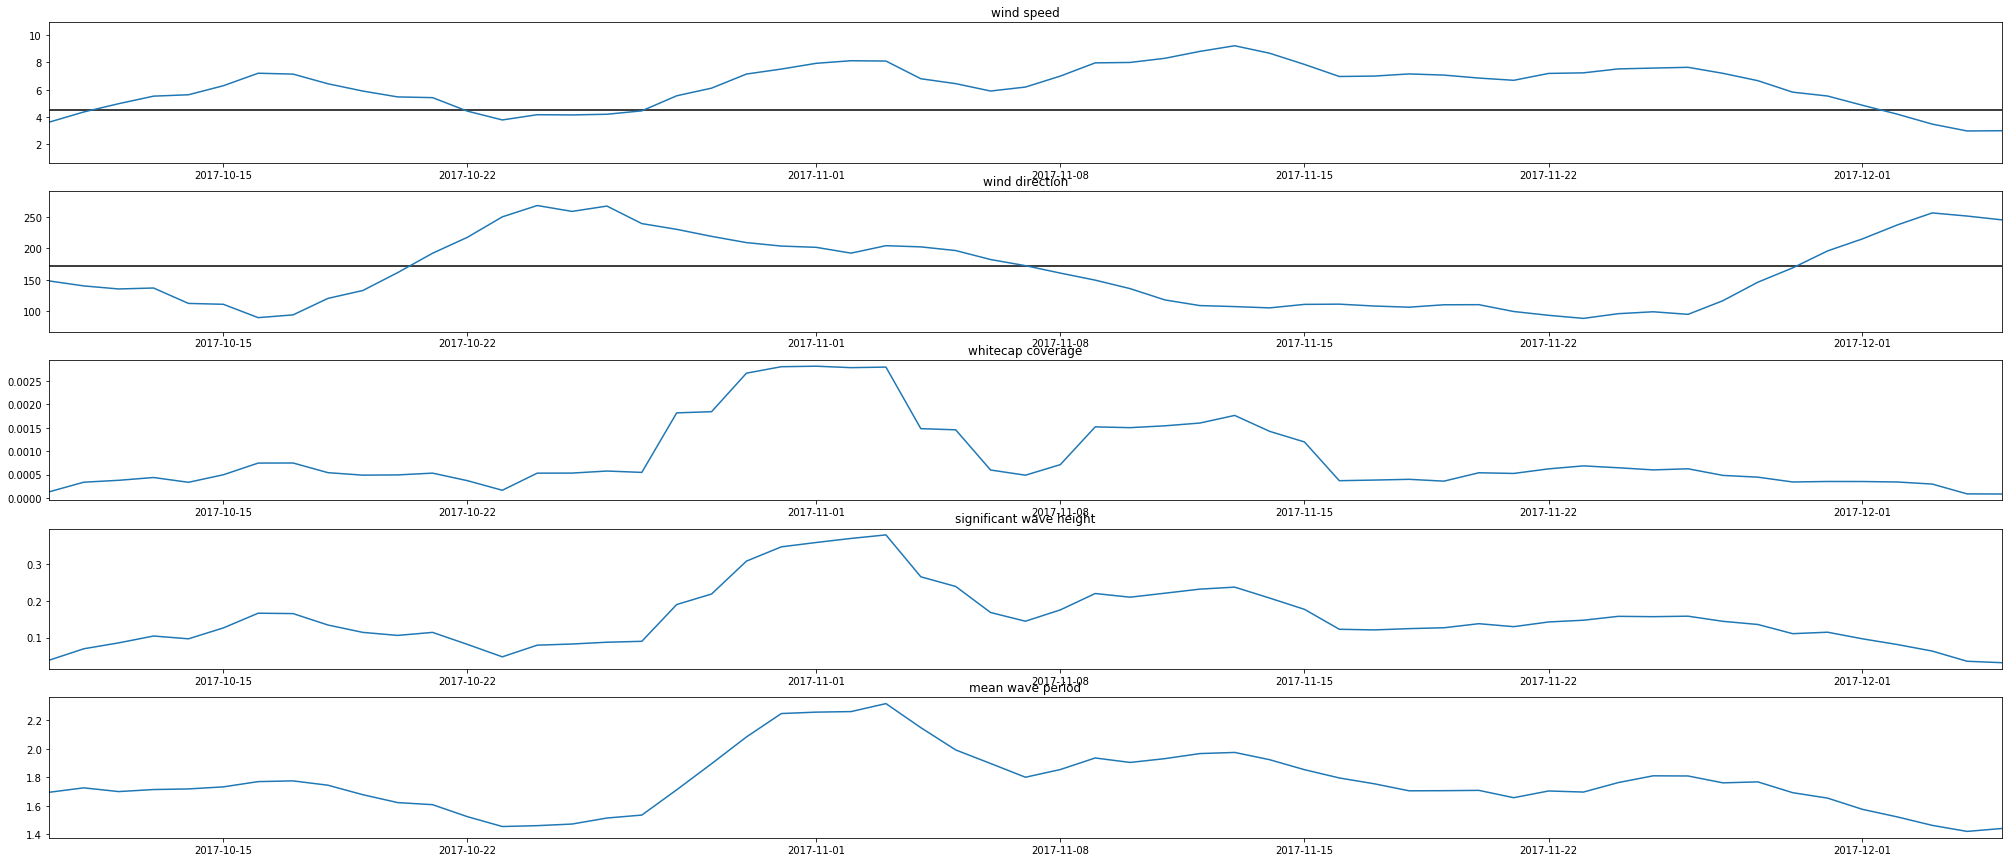

In [41]:
fig, ax = plt.subplots(5,1, figsize = (35,15))

dates2 = [datetime.date(2017,10,10) + datetime.timedelta(days = i) for i in range(57)]

ax[0].plot(dates,wnd_spd_avg)
ax[0].hlines(wind_speed2.mean(), dates2[0], dates2[-1])
ax[0].set_title('wind speed')

ax[1].plot(dates,wnd_dir_avg)
ax[1].hlines(wind_dir2.mean(), dates2[0], dates2[-1])
ax[1].set_title('wind direction')

ax[2].plot(dates2, wcc_avg)
ax[2].set_title('whitecap coverage')

ax[3].plot(dates2, swh_avg)
ax[3].set_title('significant wave height')

ax[4].plot(dates2, mwp_avg)
ax[4].set_title('mean wave period')

for a in ax:
    a.set_xlim(dates2[0], dates2[-1]);

In [42]:
wcc_avg = np.array([])
swh_avg = np.array([])
mwp_avg = np.array([])
for i in range(int(jan1018['bp_wcc'].shape[0]/48 - 7)):
    start = 48*i
    end = start + 336
    wcc_avg = np.append(wcc_avg, jan1018['bp_wcc'][start:end].mean())
    swh_avg = np.append(swh_avg, jan1018['bp_swh'][start:end].mean())
    mwp_avg = np.append(mwp_avg, jan1018['bp_mwp'][start:end].mean())
wcc_avg.shape

(51,)

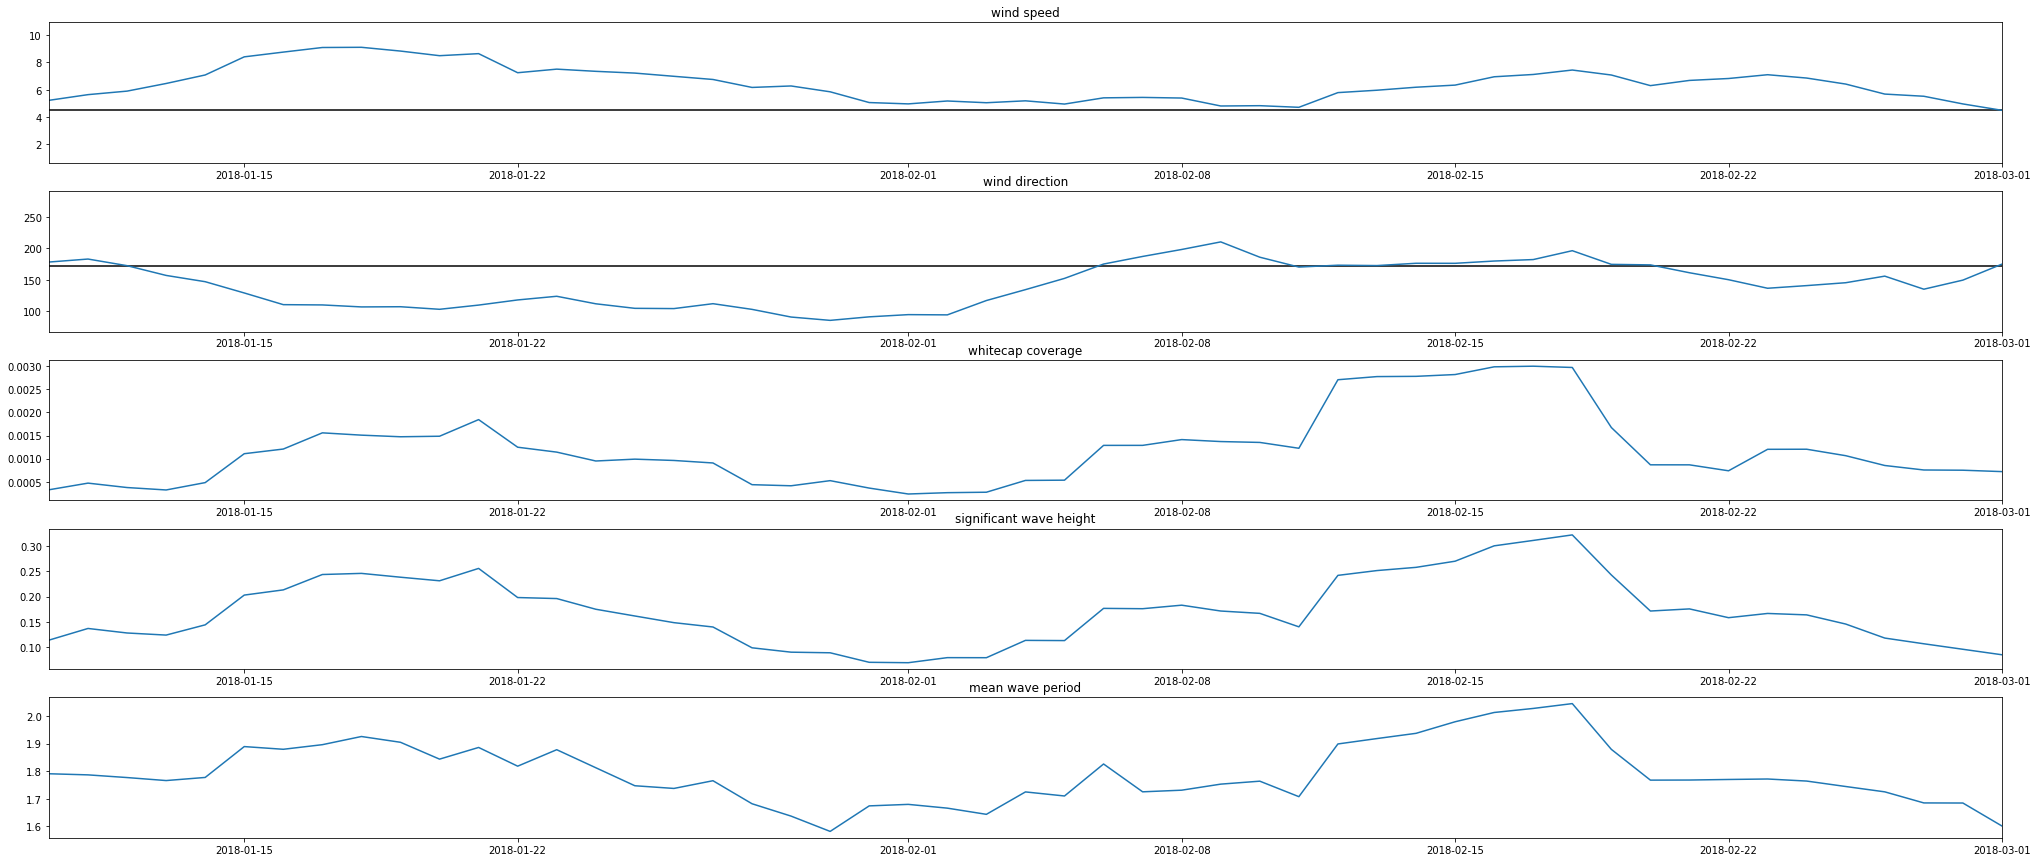

In [43]:
fig, ax = plt.subplots(5,1, figsize = (35,15))

dates2 = [datetime.date(2018,1,10) + datetime.timedelta(days = i) for i in range(51)]

ax[0].plot(dates,wnd_spd_avg)
ax[0].hlines(wind_speed2.mean(), dates2[0], dates2[-1])
ax[0].set_title('wind speed')

ax[1].plot(dates,wnd_dir_avg)
ax[1].hlines(wind_dir2.mean(), dates2[0], dates2[-1])
ax[1].set_title('wind direction')

ax[2].plot(dates2, wcc_avg)
ax[2].set_title('whitecap coverage')

ax[3].plot(dates2, swh_avg)
ax[3].set_title('significant wave height')

ax[4].plot(dates2, mwp_avg)
ax[4].set_title('mean wave period')

for a in ax:
    a.set_xlim(dates2[0], dates2[-1]);

In [44]:
wcc_avg = np.array([])
swh_avg = np.array([])
mwp_avg = np.array([])
for i in range(int(nov1518['bp_wcc'].shape[0]/48 - 7)):
    start = 48*i
    end = start + 336
    wcc_avg = np.append(wcc_avg, nov1518['bp_wcc'][start:end].mean())
    swh_avg = np.append(swh_avg, nov1518['bp_swh'][start:end].mean())
    mwp_avg = np.append(mwp_avg, nov1518['bp_mwp'][start:end].mean())
wcc_avg.shape

(47,)

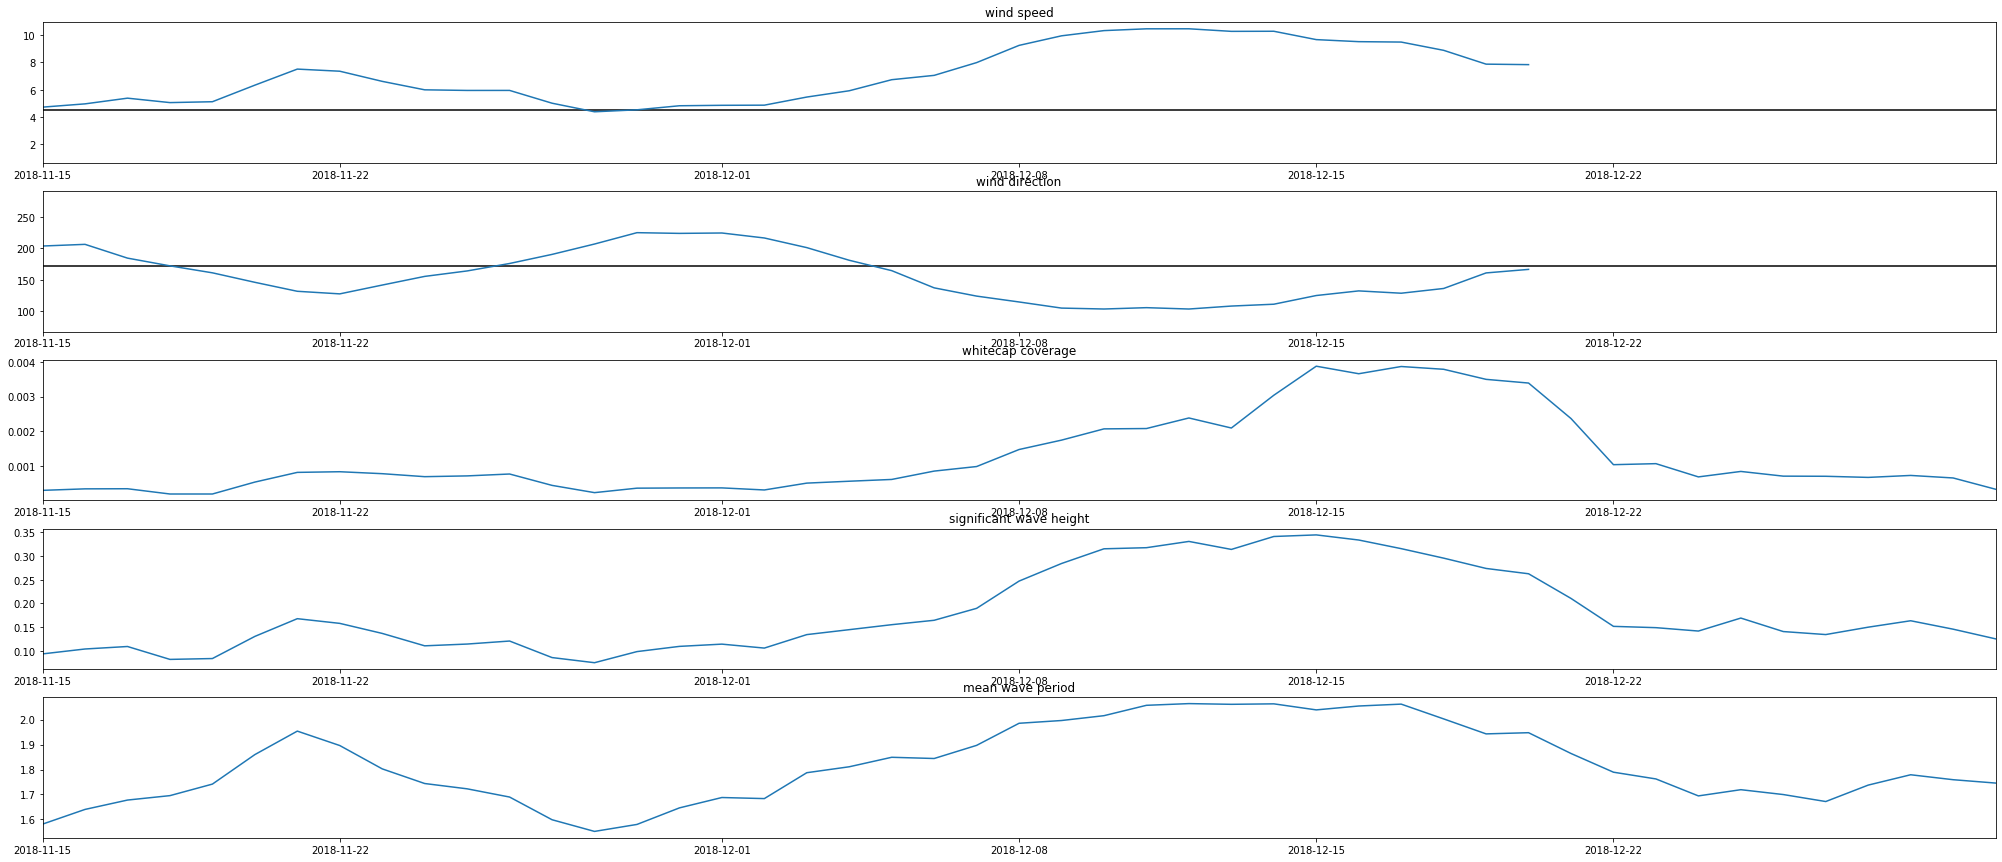

In [45]:
fig, ax = plt.subplots(5,1, figsize = (35,15))

dates2 = [datetime.date(2018,11,15) + datetime.timedelta(days = i) for i in range(47)]

ax[0].plot(dates,wnd_spd_avg)
ax[0].hlines(wind_speed2.mean(), dates2[0], dates2[-1])
ax[0].set_title('wind speed')

ax[1].plot(dates,wnd_dir_avg)
ax[1].hlines(wind_dir2.mean(), dates2[0], dates2[-1])
ax[1].set_title('wind direction')

ax[2].plot(dates2, wcc_avg)
ax[2].set_title('whitecap coverage')

ax[3].plot(dates2, swh_avg)
ax[3].set_title('significant wave height')

ax[4].plot(dates2, mwp_avg)
ax[4].set_title('mean wave period')

for a in ax:
    a.set_xlim(dates2[0], dates2[-1]);